Notebook to play with WOD data using the wodpy package

WOD data
* http://www.nodc.noaa.gov/OC5/WOD/datageo.html

wodpy package
* https://github.com/BillMills/wodpy



In [1]:
from wodpy import wod

from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import netCDF4 as nc
from salishsea_tools import viz_tools, tidetools
import numpy as np
import glob
import os
import datetime
from salishsea_tools.nowcast import analyze

%matplotlib inline

In [2]:
#make plots pretty
sns.set_style('darkgrid')

#Load Model Grid

In [3]:
f=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy=f.variables['Bathymetry'][:]
X=f.variables['nav_lon'][:]
Y=f.variables['nav_lat'][:]

#Load WOD observations

Experiment with functions to manipulate the data.

In [4]:
def read_file_to_dataframe(filename):
    """Reads a WOD file (filename) and returns data as a dataframe.
    data inlcudes columns Temperature, Salinity, Depth, Year, Month, Day, Longitude, Latitude, Datetime"""
    
    file = open(filename)
    
    #empty list for gatherting profiles.
    list_data=[]
    
    #loop through profiles
    profile = wod.WodProfile(file)
    while not profile.is_last_profile_in_file(file):
        year = profile.year()
        lat = profile.latitude()
        lon = profile.longitude()
        s=profile.s()
        d=profile.z()
        t=profile.t()
        month = profile.month()
        day = profile.day()
        date = datetime.datetime(year, month, day)
        tmp={'Year': year, 'Month': month, 'Day': day, 'Longitude': lon, 'Latitude': lat,
            'Salinity': s, 'Temperature': t, 'Depth': d, 'Datetime': date} 
        list_data.append(tmp)
        profile = wod.WodProfile(file)
        
    #again for last profile
    year = profile.year()
    lat = profile.latitude()
    lon = profile.longitude()
    s=profile.s()
    d=profile.z()
    t=profile.t()
    month = profile.month()
    day = profile.day()
    tmp={'Year': year, 'Month': month, 'Day': day, 'Longitude': lon, 'Latitude': lat,
        'Salinity': s, 'Temperature': t, 'Depth': d} 
    list_data.append(tmp)

    #convert to data frame    
    data = pd.DataFrame(list_data)     
    
    return data

In [5]:
data = read_file_to_dataframe('/ocean/nsoontie/MEOPAR/WOD/CTDS7412')    

Isolate region and plot

In [6]:
def isolate_region(data, lon_min, lon_max, lat_min, lat_max):
    """Isolates data in a rectangular region defined by lon_min, lon_max, lat_min, lat_max """
    
    data_region = data[(data['Longitude'] >  lon_min) & (data['Longitude'] < lon_max) 
                &(data['Latitude'] >lat_min) & (data['Latitude'] <lat_max)]
    
    return data_region


In [7]:
#define region and isolate
lon_min=-123.5; lat_min=49;
lon_max=-123.2; lat_max=49.2;

data_sog = isolate_region(data, lon_min, lon_max, lat_min, lat_max)

Isolate time period

In [8]:
def isolate_time_period(data, start_date, end_date):
    """Isolates a time period in the data defined by start_date and end_date, both datetime objects."""
    
    data_time = data[(data['Datetime'] >= start_date) & (data['Datetime'] <= end_date)]
    
    return data_time

In [9]:
#define time period and isolate
sdt = datetime.datetime(2000,1,1)
edt = datetime.datetime(2015,12,31)

data_recent = isolate_time_period(data_sog, sdt, edt)

What does the data frame look like?

In [10]:
data_recent.head()

,Datetime,Day,Depth,Latitude,Longitude,Month,Salinity,Temperature,Year
27660,2000-04-27,27,"[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...",49.0302,-123.4368,4,"[--, --, --, --, --, --, --, --, --, --, --, -...","[10.378, 10.042, 9.026, 8.76, 8.596, 8.478, 8....",2000
27661,2000-04-28,28,"[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...",49.0538,-123.3732,4,"[--, --, --, --, --, --, --, --, --, --, --, -...","[9.834, 10.142, 9.531, 9.029, 8.6, 8.398, 8.29...",2000
28014,2000-07-19,19,"[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...",49.0297,-123.4370,7,"[16.504, 22.536, 27.254, 28.514, 28.857, 28.95...","[16.386, 15.082, 12.939, 11.269, 10.515, 10.35...",2000
28015,2000-07-19,19,"[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...",49.0547,-123.3730,7,"[11.407, 21.645, 27.159, 28.49, 28.811, 29.048...","[16.559, 15.711, 12.776, 11.171, 10.824, 10.27...",2000
28045,2000-07-21,21,"[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...",49.0062,-123.4587,7,"[23.419, 24.954, 28.219, 28.442, 28.879, 29.08...","[18.056, 15.438, 11.439, 11.191, 10.69, 10.305...",2000


Examine data by plotting

(48.4, 49.5)

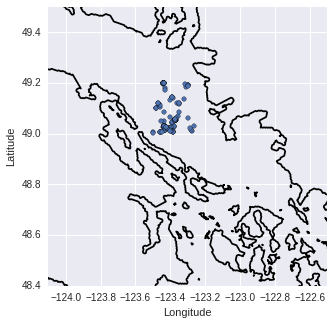

In [11]:
fig,axm = plt.subplots(1,figsize=(5,5))
data_recent.plot(x='Longitude',y='Latitude',kind='scatter', marker='o',ax=axm)
viz_tools.plot_coastline(axm,f,coords='map')
axm.set_xlim([-124.1,-122.5])
axm.set_ylim([48.4,49.5])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7fa2cb7050>]], dtype=object)

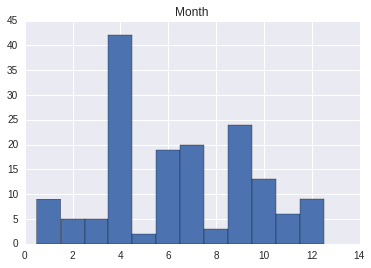

In [12]:
data_recent.hist('Month',bins=np.arange(0.5,13.5))

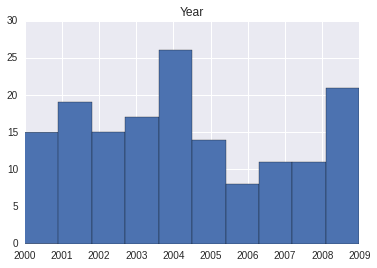

In [13]:
data_recent.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

#Model comparisons

Plan: 
* Compare this data set with spin-up year and nowcasts. 
* Spin-up year uses climatology for rivers so shouldn't need to worry as much about river discharge.
* Maybe it is better to avoid comparisons during the high flow months due to the interannual variability.

In [14]:
def load_model(model_path, start_date, end_date, field, nowcast_flag=False):
    """Loads model grid_T data in date range defined by start_date and end_date
    Only consideres daily averaged model fields.
    Returns model depths, variable defined by field, and dates associated with cariable
    """
    
    files = analyze.get_filenames(start_date, end_date,'1d','grid_T',model_path)
    if nowcast_flag:
        var, dates = analyze.combine_files(files, field, np.arange(0,40), np.arange(0,898),np.arange(0,398))
        tmp = nc.Dataset(files[0])
        depth = tmp.variables['deptht'][:]
    
    else:
        tracers = nc.MFDataset(files)
        time = tracers.variables['time_counter']
        #convert date
        dates=[]; start=datetime.datetime.strptime(time.time_origin,' %Y-%b-%d %H:%M:%S')
        for t in time[:]:
            d = start + datetime.timedelta(seconds=t)
            dates.append(d)
        depth = tracers.variables['deptht'][:]
        var = tracers.variables[field][:]
        
    return depth, var, dates

In [15]:
def compare_model_obs(month, model_year, field, data_obs, model_path,
                   xmin=-124,xmax=-122,ymin=48,ymax=50,zmin=0,zmax=300, vmin=10,vmax=32 ):
    """Compares the observations from WOD with model output on the same day and at a close grid point.
    Comparisons are during single month.
    field is compared ('Temperature' or 'Salinity' )
    Observations stored in data_obs (DataFrame)
    Model_path defines where the model data is stored (can be nowcast or spinup)
    """
    
    fig, [ax, axm] = plt.subplots(1,2,figsize=(10,3))
    
    #date ranges based on month and model_year
    sdt = datetime.datetime(model_year, month, 1)
    edt = sdt + datetime.timedelta(days=31)
    
    #Model variables and nowcast/spinup?
    if field=='Salinity':
        model_field='vosaline'
    elif field =='Temperatute':
        model_field='votemper'
    #Is this a nowcast?
    if model_year == 2014 or model_year ==2015:
        nowcast_flag = True
        title='Nowcast'
    else:
        nowcast_flag = False
        title='Spinup'
        
    #load model variables    
    depth_mod, var_mod, dates_mod= load_model(model_path, sdt, edt, model_field, nowcast_flag=nowcast_flag)
   
    #plot obs and model
    data_m = data_obs[data_obs['Month']==month]
    for dep_obs, var_obs, lon, lat, day in zip(data_m['Depth'],data_m[field], data_m['Longitude'], 
                                          data_m['Latitude'],data_m['Day']):
        #model grid points
        [j,i]=tidetools.find_closest_model_point(lon,lat,X,Y,bathy) #X,Y,bathy loaded in notebook
        #model time index
        for count,date in enumerate(dates_mod):
            if date.day==day:
                t_ind =count 
        var_plot=var_mod[t_ind,:,j,i]
        var_plot=np.ma.masked_values(var_plot,0)
        
        ax.plot(var_obs, dep_obs,'-*r',label = 'obs',alpha=0.5)
        if j:
            ax.plot(var_plot, depth_mod,'-ob',label = 'model',alpha=0.5)
        #plot location on map
        axm.plot(lon,lat,'*r')
    
    #Set plot axis and labels
    ax.set_ylim([zmax,zmin])
    ax.set_xlim([vmin,vmax])
    ax.set_title(title)
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel(field)

    #plot mode coastline 
    viz_tools.plot_coastline(axm,f,coords='map') #f defined oustide of function
    axm.set_ylim([ymin,ymax])
    axm.set_xlim([xmin,xmax])
    axm.set_title('Month {}'.format(month))
    
    #fake the legend
    simObs, = ax.plot(-1,0,'r*')
    simMod, = ax.plot(-1,0,'bo')
    ax.legend([simObs,simMod], ['obs','model'],loc=0)

    
    return fig

In [16]:
paths = {'nowcast': '/data/dlatorne/MEOPAR/SalishSea/nowcast/',
        'spinup': '/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/'}
zmax=20

November

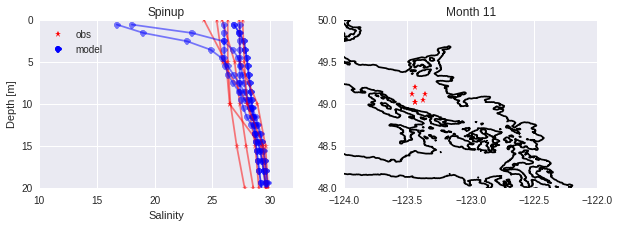

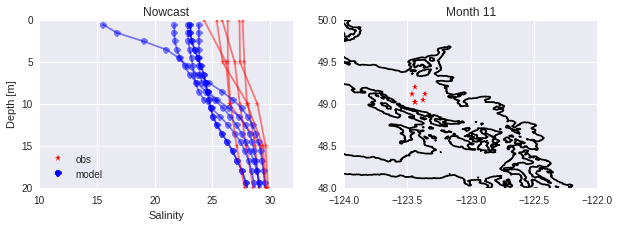

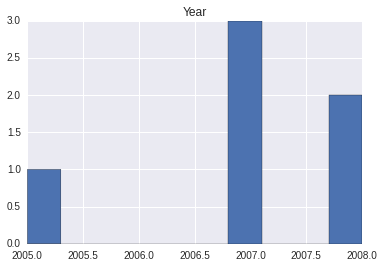

In [17]:
month=11
fig=compare_model_obs(month,2003,'Salinity',data_recent,paths['spinup'],zmax=zmax)
fig=compare_model_obs(month,2014,'Salinity',data_recent,paths['nowcast'],zmax=zmax)
data_month=data_recent[data_recent['Month']==month]
data_month.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

December

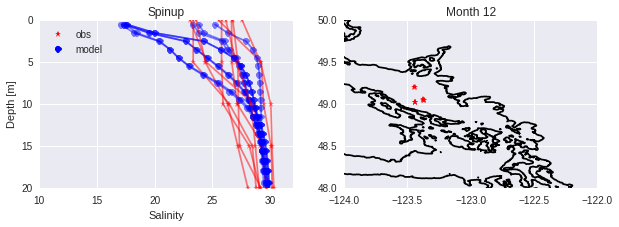

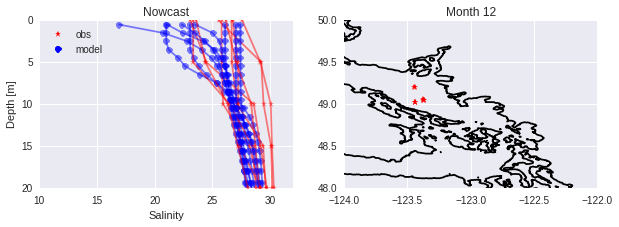

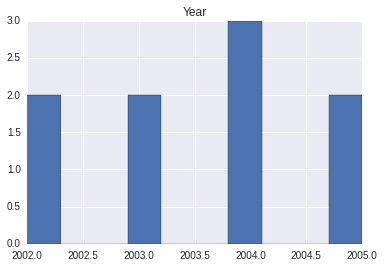

In [18]:
month=12
fig=compare_model_obs(month,2003,'Salinity',data_recent,paths['spinup'],zmax=zmax)
fig=compare_model_obs(month,2014,'Salinity',data_recent,paths['nowcast'],zmax=zmax)
data_month=data_recent[data_recent['Month']==month]
data_month.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

January

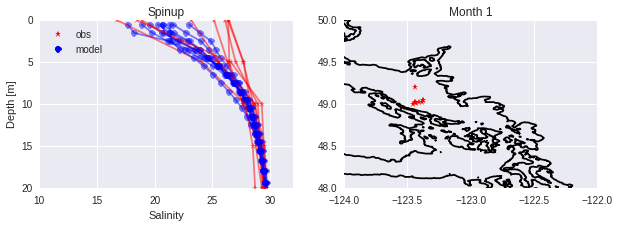

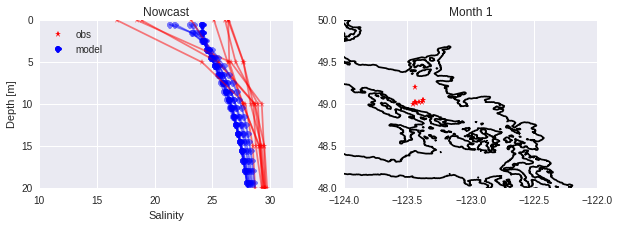

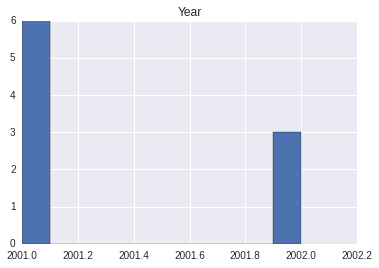

In [19]:
month=1
fig=compare_model_obs(month,2003,'Salinity',data_recent,paths['spinup'],zmax=zmax)
fig=compare_model_obs(month,2015,'Salinity',data_recent,paths['nowcast'],zmax=zmax)
data_month=data_recent[data_recent['Month']==month]
data_month.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

February

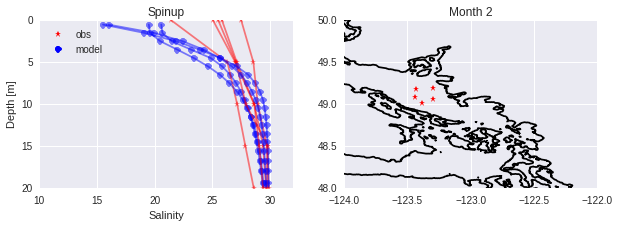

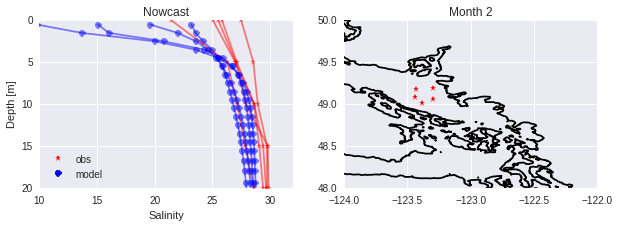

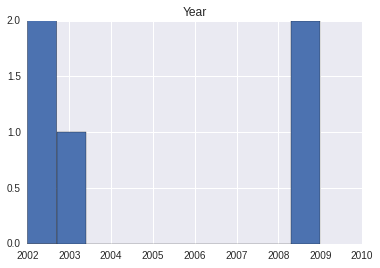

In [20]:
month=2
fig=compare_model_obs(month,2003,'Salinity',data_recent,paths['spinup'],zmax=zmax)
fig=compare_model_obs(month,2015,'Salinity',data_recent,paths['nowcast'],zmax=zmax)
data_month=data_recent[data_recent['Month']==month]
data_month.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

March

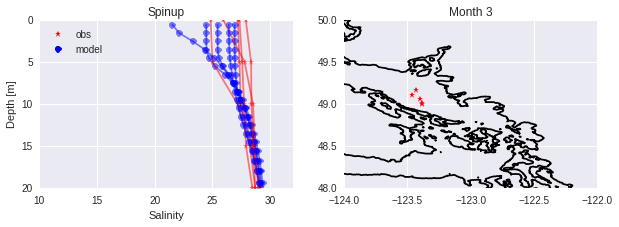

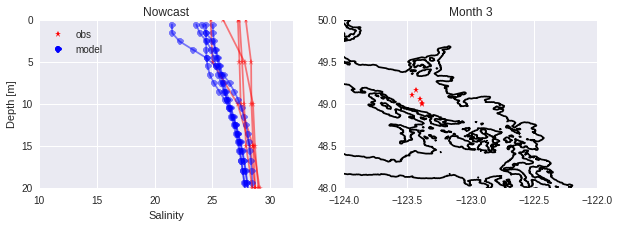

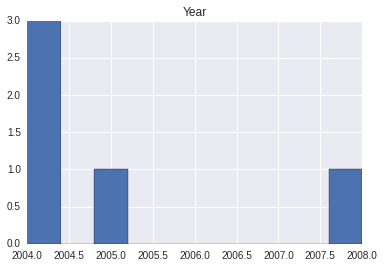

In [21]:
month=3
fig=compare_model_obs(month,2003,'Salinity',data_recent,paths['spinup'],zmax=zmax)
fig=compare_model_obs(month,2015,'Salinity',data_recent,paths['nowcast'],zmax=zmax)
data_month=data_recent[data_recent['Month']==month]
data_month.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

April

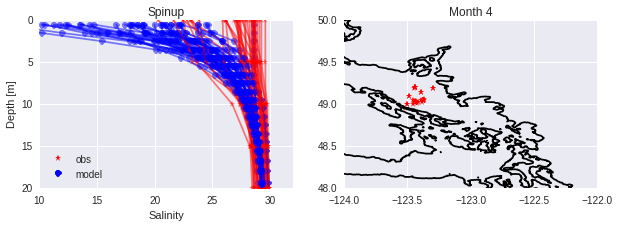

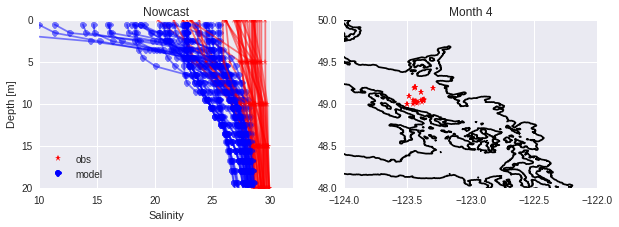

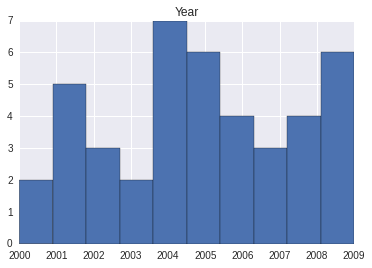

In [22]:
month=4
fig=compare_model_obs(month,2003,'Salinity',data_recent,paths['spinup'],zmax=zmax)
fig=compare_model_obs(month,2015,'Salinity',data_recent,paths['nowcast'],zmax=zmax)
data_month=data_recent[data_recent['Month']==month]
data_month.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

Note: large April discharge in 2015 so expecting model nowcasts to be much fresher. But why is spinup so fresh?

May

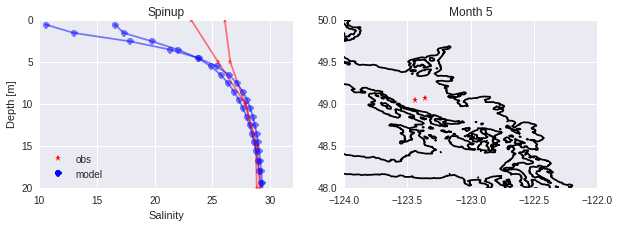

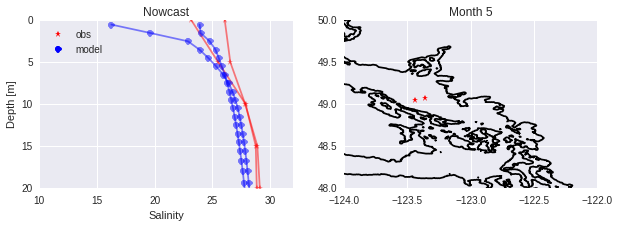

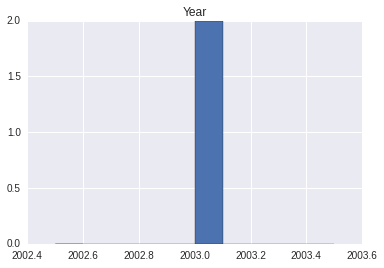

In [23]:
month=5
fig=compare_model_obs(month,2003,'Salinity',data_recent,paths['spinup'],zmax=zmax)
fig=compare_model_obs(month,2015,'Salinity',data_recent,paths['nowcast'],zmax=zmax)
data_month=data_recent[data_recent['Month']==month]
data_month.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

June

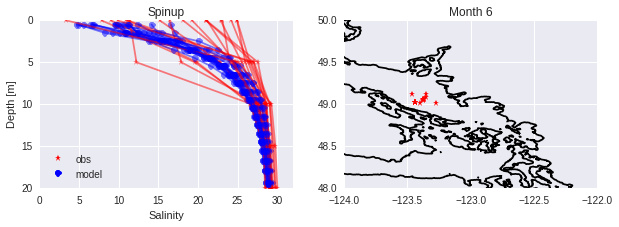

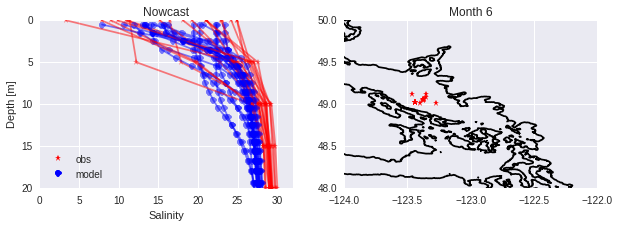

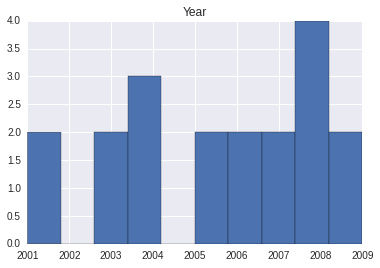

In [24]:
month=6
fig=compare_model_obs(month,2003,'Salinity',data_recent,paths['spinup'],vmin=0,zmax=zmax)
fig=compare_model_obs(month,2015,'Salinity',data_recent,paths['nowcast'],vmin=0,zmax=zmax)
data_month=data_recent[data_recent['Month']==month]
data_month.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

Starting to get into the large discharge time. It might be harder to make fair comparisons here because there is so much interannual variability in the discharge. Will think about this...

July

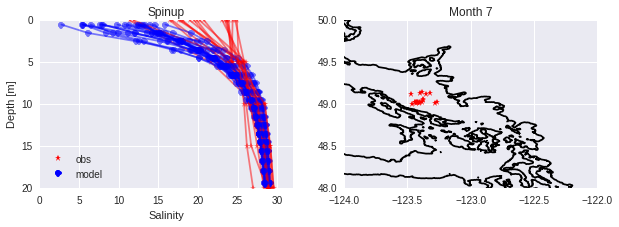

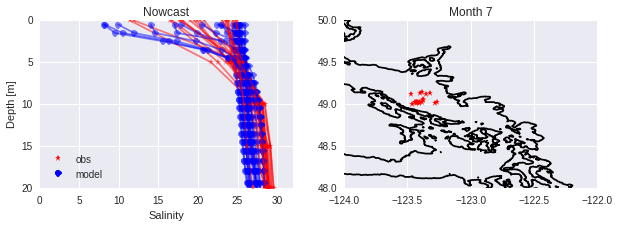

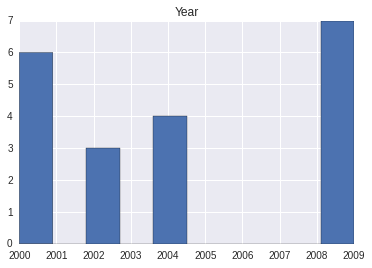

In [25]:
month=7
fig=compare_model_obs(month,2003,'Salinity',data_recent,paths['spinup'],vmin=0,zmax=zmax)
fig=compare_model_obs(month,2015,'Salinity',data_recent,paths['nowcast'],vmin=0,zmax=zmax)
data_month=data_recent[data_recent['Month']==month]
data_month.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)